Before running, choose Runtime > Change runtime type and select GPU.


# Setup



In [1]:
!pip install pandas
!pip install seaborn
!pip install sentence_transformers
!pip install sklearn
!pip install transformers
!pip install torch

In [2]:
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
import torch
from tqdm.notebook import tqdm
from transformers import GPT2Tokenizer, GPT2LMHeadModel

%matplotlib inline

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer.eos_token_id)
model.eval().cuda()

2022-04-26 22:46:53.612257: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 22:46:53.612280: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# GPT-2 Utility functions

Resources:

1.   https://huggingface.co/transformers/model_doc/gpt2.html#gpt2lmheadmodel
2.   https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-generation/run_generation.py




In [3]:
def generate(prompt, max_length=5, stop_token=None):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    generated_text_ids = model.generate(input_ids=input_ids.cuda(), max_length=max_length+len(input_ids[0]), do_sample=False)
    generated_text = tokenizer.decode(generated_text_ids[0], clean_up_tokenization_spaces=True)
    post_prompt_text = generated_text[len(tokenizer.decode(input_ids[0], clean_up_tokenization_spaces=True)):]
    return prompt + post_prompt_text[:post_prompt_text.find(stop_token) if stop_token else None]

In [4]:
# Note that the logits are shifted over 1 to the left, since HuggingFace doesn't give a logit for the first token
def get_logits_and_tokens(text):
    input_ids = tokenizer.encode(text, return_tensors="pt")
    tokens = [tokenizer.decode([input_id]) for input_id in input_ids[0]]
    output = model(input_ids.cuda())
    return output.logits[0][:-1], tokens

# Example calls to GPT-2 Utility functions

In [5]:
EXAMPLE_PROMPT = """I tested positive\nHe tested positive\nShe tested"""

generated_text = generate(EXAMPLE_PROMPT, stop_token="\n")

In [6]:
logits, tokens = get_logits_and_tokens(generated_text)
last_token_probs = torch.softmax(logits[-1], dim=0)
negative_prob = last_token_probs[tokenizer.encode(" negative")[0]]
positive_prob = last_token_probs[tokenizer.encode(" positive")[0]]

print(f"tokens: {tokens}\nnegative prob: {negative_prob}\npositive prob: {positive_prob}")

tokens: ['I', ' tested', ' positive', '\n', 'He', ' tested', ' positive', '\n', 'She', ' tested', ' positive']
negative prob: 0.086564801633358
positive prob: 0.9039686918258667


# Loading the data

Note: before running this section load `train.jsonl` into the runtime

In [7]:
def load_jsonl(filename):
    f = open(filename)
    return [json.loads(line) for line in f.read().splitlines()]

In [8]:
train_examples = load_jsonl("train.jsonl")
valid_examples = load_jsonl("dev.jsonl")

# Basic prompt building

In [9]:
def render_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
Label: {example["label"]}"""

In [10]:
def render_end_example(example):
    title = example["text"].split(".")[0].strip()
    abstract = example["text"][len(title)+1:].strip()
    return f"""Title: {title}
Abstract: {abstract}
Label:"""

In [11]:
def make_prompt(instructions, train_examples, end_example):
    rendered_train_examples = "\n\n--\n\n".join([render_example(example) for example in train_examples])
    return f"""{instructions}

{rendered_train_examples}

--

{render_end_example(end_example)}"""

# Few-Shot Classification using 2 examples

- Create a prompt from 2 randomly drawn examples (1 positive, 1 negative)
- Generate a response to the prompt
- Compare response to label

In [12]:
def process_labels(examples):
    label_map = {
        "True": "positive", 
        "False": "negative",
        "positive": "positive",
        "negative": "negative",
    }
    for article in examples:
        if "label" not in article:
            return examples
        article["label"] = label_map[article["label"]]
    return examples

In [13]:
class ArticleClassificationDataset(torch.utils.data.Dataset):
    """
    Container for articles.
    
    Stores a list `articles` of dictionaries with "text", "label", and "meta" fields.
    Also stores a dictionary `class_idxs` from labels to indices in `articles`.
    """
    
    def __init__(self, articles):
        self.articles = process_labels(articles)
        self.labels = ["positive", "negative"]
        self.class_idxs = {}
        for label in self.labels:
            self.class_idxs[label] = [
                i for (i, article) in enumerate(self.articles) if "label" in article and article["label"] == label
            ]
        self.has_labels = "label" in self.articles[0]
    
    def __len__(self):
        return len(self.articles)
    
    def __getitem__(self, idx):
        return self.articles[idx]
    
    def articles_with_label(self, label=None):
        """
        Return all articles with the given label.
        """
        return [self.articles[i] for i in self.class_idxs[label]] if label else self.articles

    def random_articles(self, num_articles_per_label):
        """
        Return randomly-selected articles with the specified labels.
        
        E.g. `self.random_articles({"positive": 3, "negative": 5})` return 3 positive and 5 negative articles,
            in a random order
        """
        articles = []
        for label, num_articles in num_articles_per_label.items():
            articles = np.append(articles, np.random.choice(self.articles_with_label(label), num_articles))
        np.random.shuffle(articles)
        return articles
    

train_data = ArticleClassificationDataset(train_examples)
valid_data = ArticleClassificationDataset(valid_examples)

train_data_subset = ArticleClassificationDataset(train_data.random_articles({"positive": 5, "negative": 15}))

  0%|          | 0/500 [00:00<?, ?it/s]

(['positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'pos

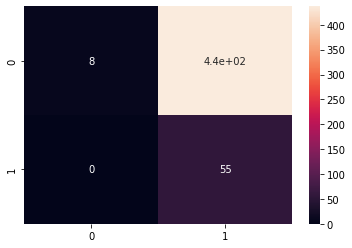

In [14]:
def classify_few_shot(
    instructions: str, 
    train_articles: ArticleClassificationDataset, 
    valid_articles: ArticleClassificationDataset, 
    num_pos: int = 1, 
    num_neg: int = 1,
    seed: int = 31
):
    """
    Classify all articles in validation set by prompting with:
    - 1 positive title/abstract from training set + "Label: positive" (i.e. "AI")
    - 1 negative title/abstract from training set + "Label: negative" (i.e. "Not AI")
    - the title/abstract from validation set + "Label:"
    
    :param instructions: instructions at beginning of prompt
    :param train_articles: articles with examples for few-shot prompting
    :param valid_articles: articles to classify
    :num_pos: number of positive examples in prompt
    :num_neg: number of negative examples in prompt
    :return: lists of predictions ("positive" or "negative") for each article, and the true 
    """
    np.random.seed(seed)
    
    num_articles_per_label = {"positive": num_pos, "negative": num_neg}
    pred_labels = []
    true_labels = []
    
    for article in tqdm(valid_articles):
        few_shot_articles = train_articles.random_articles(num_articles_per_label)
        prompt = make_prompt(instructions, few_shot_articles, article)
        generated_text = generate(prompt, stop_token="\n")
        pred_label = generated_text.split(" ")[-1]
        true_label = article["label"]
        pred_labels.append(pred_label)
        true_labels.append(true_label)
    
    sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True)
    return pred_labels, true_labels


instructions = "Classify the following examples based on whether they are AI-relevant or not:"
classify_few_shot(instructions, train_data_subset, valid_data, seed=31)

# Few-shot classification using only titles

Same as before, but omitting the article text.

This enables us to pass more examples in the prompt (e.g. 5 positive, 10 negative)

  0%|          | 0/500 [00:00<?, ?it/s]

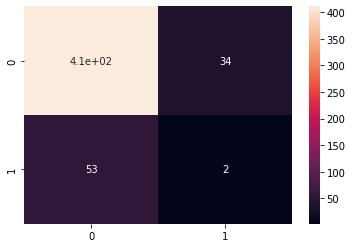

In [15]:
def examples_with_titles(examples):
    titles = deepcopy(examples)
    for article in titles:
        article["text"] = article["text"].split(".")[0]
    return titles

train_titles_data = ArticleClassificationDataset(examples_with_titles(train_examples))
valid_titles_data = ArticleClassificationDataset(examples_with_titles(valid_examples))

train_titles_data_subset = ArticleClassificationDataset(
    train_titles_data.random_articles({"positive": 5, "negative": 15})
)

pred_labels, true_labels = classify_few_shot(
    instructions, train_titles_data_subset, valid_titles_data, num_pos=5, num_neg=10, seed=31
)

# Changing the instructions

Try giving GPT-2 more specific instructions.

  0%|          | 0/500 [00:00<?, ?it/s]

(['positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'negative',
  'positive',
  'positive',
  'pos

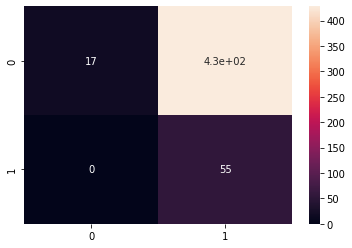

In [16]:
instructions = "Respond with \"positive\" if the article relates to AI, or \"negative\" if the article does not relate to AI:"
classify_few_shot(instructions, train_data_subset, valid_data, seed=31)

  0%|          | 0/500 [00:00<?, ?it/s]

(['positive',
  'positive',
  'positive',
  'positive',
  'negative',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'negative',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'negative',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'positive',
  'negative',
  'positive',
  'positive',
  'pos

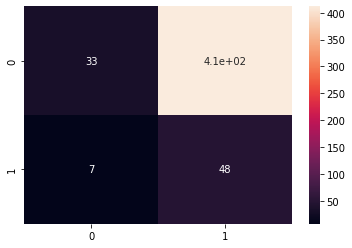

In [17]:
instructions = "Respond with \"positive\" if the article relates to AI, or \"negative\" if the article does not relate to AI:"
classify_few_shot(instructions, train_titles_data_subset, valid_titles_data, seed=31)

# Similarity to labeled examples

Let's encode sentences with SBERT, and see whether the embeddings will help us to classify articles.

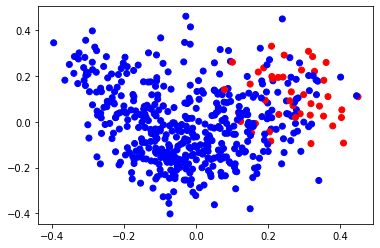

In [18]:
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1').eval().cuda()
text_embeddings = model.encode([article["text"] for article in train_data])
pca_model = PCA(n_components=10)
embedding_pca_train = pca_model.fit_transform(text_embeddings)
colors = ["red" if article["label"] == "positive" else "blue" for article in train_data]
plt.scatter(embedding_pca_train[:, 0], embedding_pca_train[:, 1], c=colors)

With only 2 principle components, the points are almost separable (red = "AI", blue = "not AI"). With more PCs, we can use a KNN approach to classify the articles from the validation set (using only 5 positive and 15 negative examples).

In [19]:
pca = PCA(n_components=20)
pca.fit(text_embeddings)

PCA(n_components=20)

In [24]:
def classify_articles_with_knn(
    test_data,
    knn_n_neighbors=2,
    threshold=0.5,
):
    # get embeddings for 20 labeled examples
    train_embeddings = model.encode([article["text"] for article in train_data_subset])
    train_embeddings = pca.transform(train_embeddings)
    int_labels = [1 if article["label"] == "positive" else 0 for article in train_data_subset]

    # fit KNN on labeled examples
    knn = KNeighborsRegressor(n_neighbors=knn_n_neighbors)
    knn.fit(train_embeddings, int_labels)

    # predict validation embeddings using threshold
    test_embeddings = model.encode([article["text"] for article in test_data])
    test_embeddings = pca.transform(test_embeddings)
    y_pred = knn.predict(test_embeddings)
    pred_labels = ["positive" if val > threshold else "negative" for val in y_pred]
    
    if test_data.has_labels:
        true_labels = [article["label"] for article in test_data]
        sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True)
        true_pos = 0
        false_neg = 0
        false_pos = 0
        true_neg = 0
        N = len(true_labels)
        for i in range(N):
            if true_labels[i] == "positive":
                if pred_labels[i] == "positive":
                    true_pos += 1
                else:
                    false_neg += 1
            else:
                if pred_labels[i] == "positive":
                    false_pos += 1
                else:
                    true_neg += 1

        print(f"Accuracy: {(true_pos + true_neg) / N:.3f}")
        print(f"Precision: {true_pos / (true_pos + false_pos):.3f}")
        print(f"Recall: {true_pos / (true_pos + false_neg):.3f}")
        
    return pred_labels

Accuracy: 0.900
Precision: 0.556
Recall: 0.455


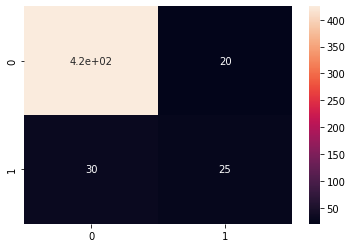

In [35]:
pred_labels = classify_articles_with_knn(
    valid_data,
    knn_n_neighbors=4,
    threshold=0.5,
)

# Generate test labels

In [37]:
# classify test articles
test_examples = load_jsonl("test_no_labels.jsonl")
test_data = ArticleClassificationDataset(test_examples)
pred_labels = classify_articles_with_knn(
    test_data,
    knn_n_neighbors=4,
    threshold=0.5,
)

# add labels and save jsonl
for i in range(len(pred_labels)):
    test_data[i]["label"] = "AI" if pred_labels[i] == "positive" else "Not AI"
with open("test_with_labels.jsonl", "w") as f:
    for article in test_data:
        f.write(json.dumps(article) + "\n")